<a href="https://colab.research.google.com/github/AlvinScrp/LLMs-from-scratch-CN/blob/main/mini-gpt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 一个简单的GPT2

In [1]:
# NBVAL_IGNORE_OUTPUT
from importlib.metadata import version

print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))
import tiktoken
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

torch version: 2.8.0+cu126
tiktoken version: 0.12.0


## 数据加载
* 文本：the-verdict.txt
* gpt2 tokenizer
* Dataloader
* token_embedding position_embedding


In [2]:
import os##导入os库
import urllib.request ##导入request库

if not os.path.exists("the-verdict.txt"):##如果文件不存在则创建，防止因文件已存在而报错
    url = ("https://raw.githubusercontent.com/rasbt/"
           "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
           "the-verdict.txt")
    print(url)
    file_path = "the-verdict.txt"
    urllib.request.urlretrieve(url, file_path)##从指定的地点读取文件
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()  # 读取文本文件
#raw_text 后续使用

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []  # 输入ID列表
        self.target_ids = []  # 目标ID列表

        # 对整个文本进行分词
        token_ids = tokenizer.encode(txt, allowed_special={'<|endoftext|>'})

        # 使用滑动窗口将文本分割成重叠的最大长度序列
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]  # 输入片段
            target_chunk = token_ids[i + 1: i + max_length + 1]  # 目标片段（右移一个位置）
            self.input_ids.append(torch.tensor(input_chunk))  # 将输入片段转换为张量
            self.target_ids.append(torch.tensor(target_chunk))  # 将目标片段转换为张量

    def __len__(self):
        return len(self.input_ids)  # 返回数据集的大小

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]  # 获取特定索引的输入和目标

def create_dataloader(txt, batch_size=4, max_length=256, stride=128, shuffle=True):
    # 初始化分词器
    tokenizer = tiktoken.get_encoding("gpt2")
    # 创建数据集
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    # 创建数据加载器
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    return dataloader  # 返回数据加载器

vocab_size = 50257  # 词汇表大小
output_dim = 256  # 输出维度
max_len = 1024  # 最大序列长度
context_length = max_len  # 上下文长度


token_embedding_layer = nn.Embedding(vocab_size, output_dim)  # 创建词嵌入层
pos_embedding_layer =  nn.Embedding(context_length, output_dim)  # 创建位置嵌入层

max_length = 4  # 每个输入片段的最大长度
dataloader = create_dataloader(raw_text, batch_size=8, max_length=max_length, stride=max_length)  # 创建数据加载器

https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt


测试代码

In [3]:
tokenizer = tiktoken.get_encoding("gpt2")  # 初始化分词器
encoded_text = tokenizer.encode(raw_text)  # 对文本进行编码
print(raw_text[:50])
print(encoded_text[:8])
print(tokenizer.decode(encoded_text[:8]))
print('-'*20)
for batch in dataloader:
    x, y = batch

    token_embeddings = token_embedding_layer(x)
    pos_embeddings = pos_embedding_layer(torch.arange(max_length))

    input_embeddings = token_embeddings + pos_embeddings

    break
print(input_embeddings.shape)

I HAD always thought Jack Gisburn rather a cheap g
[40, 367, 2885, 1464, 1807, 3619, 402, 271]
I HAD always thought Jack Gis
--------------------
torch.Size([8, 4, 256])


## 注意力机制

- 以下是之前实现的自注意力机制总结（为简化起见，未展示因果和dropout掩码）：

- 这种机制也称为单头注意力：

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/24.webp" width="400px">

- 我们通过堆叠多个单头注意力模块来构建多头注意力模块：

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/25.webp" width="400px">

- 多头注意力的核心思想是使用不同的学习到的线性投影，并行地多次运行注意力机制。这使得模型能够在不同位置同时关注来自不同表示子空间的信息。
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/26.webp" width="400px">

### 带掩码的单头自注意力
仅示例，后续不会用到

In [4]:
class CausalSelfAttention(nn.Module):
    """
    该类实现了因果自注意力机制（Causal Self Attention），
    用于自回归模型（例如GPT模型中的注意力层）。
    """

    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
        """
        初始化因果自注意力层。

        参数：
        - d_in: 输入维度
        - d_out: 输出维度
        - context_length: 上下文长度（即注意力机制能“看到”的最大令牌数）
        - dropout: Dropout率
        - qkv_bias: 是否为查询、键和值使用偏置（默认为False）
        """
        super().__init__()
        self.d_out = d_out
        # 定义查询、键、值的线性变换
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        # Dropout层
        self.dropout = nn.Dropout(dropout)  # 新增的Dropout层

        # 注册一个buffer，用于存储因果掩码
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))  # 新增掩码，禁止未来的信息

    def forward(self, x):
        """
        前向传播函数计算因果自注意力输出。

        参数：
        - x: 输入的张量，形状为 (batch_size, num_tokens, d_in)

        返回：
        - context_vec: 自注意力机制的输出，形状为 (batch_size, num_tokens, d_out)
        """
        b, n_tokens, d_in = x.shape  # 获取输入张量的维度
        keys = self.W_key(x)  # 键（K）
        queries = self.W_query(x)  # 查询（Q）
        values = self.W_value(x)  # 值（V）

        # 计算注意力分数（查询和键的点积）
        attn_scores = queries @ keys.transpose(1, 2)  # 这里的转置（transpose）是为了匹配维度

        # 使用掩码阻止未来的tokens看到当前token
        attn_scores.masked_fill_(  # 这里的操作是原地修改
            self.mask.bool()[:n_tokens, :n_tokens], -torch.inf)  # 将掩码区域填充为负无穷

        # 计算注意力权重并进行softmax归一化
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)  # 使用Dropout层

        # 计算上下文向量（加权和）
        context_vec = attn_weights @ values
        return context_vec

In [5]:
mask =torch.triu(torch.ones(4,4),diagonal=1)
# print(mask)
q=(torch.arange(1,25)*0.1).reshape(2,4,3).float() # Cast to float
k=(torch.arange(1,25)*0.1).reshape(2,4,3).float() # Cast to float
print(q)
score = q@k.transpose(1,2)
print(score)
print(torch.bmm(q,k.transpose(1,2)))
print(mask.bool())
score_masked =score.masked_fill_(mask.bool()[:4,:4],-torch.inf)
print(score_masked)
score_masked_softmax = torch.softmax(score_masked,dim=-1)
print(score_masked_softmax)

tensor([[[0.1000, 0.2000, 0.3000],
         [0.4000, 0.5000, 0.6000],
         [0.7000, 0.8000, 0.9000],
         [1.0000, 1.1000, 1.2000]],

        [[1.3000, 1.4000, 1.5000],
         [1.6000, 1.7000, 1.8000],
         [1.9000, 2.0000, 2.1000],
         [2.2000, 2.3000, 2.4000]]])
tensor([[[ 0.1400,  0.3200,  0.5000,  0.6800],
         [ 0.3200,  0.7700,  1.2200,  1.6700],
         [ 0.5000,  1.2200,  1.9400,  2.6600],
         [ 0.6800,  1.6700,  2.6600,  3.6500]],

        [[ 5.9000,  7.1600,  8.4200,  9.6800],
         [ 7.1600,  8.6900, 10.2200, 11.7500],
         [ 8.4200, 10.2200, 12.0200, 13.8200],
         [ 9.6800, 11.7500, 13.8200, 15.8900]]])
tensor([[[ 0.1400,  0.3200,  0.5000,  0.6800],
         [ 0.3200,  0.7700,  1.2200,  1.6700],
         [ 0.5000,  1.2200,  1.9400,  2.6600],
         [ 0.6800,  1.6700,  2.6600,  3.6500]],

        [[ 5.9000,  7.1600,  8.4200,  9.6800],
         [ 7.1600,  8.6900, 10.2200, 11.7500],
         [ 8.4200, 10.2200, 12.0200, 13.8200],
     

### 多头注意力
实际是合并多头权重，做矩阵运算。  而不是分别遍历单头计算，再合并

In [6]:
class MultiHeadAttention(nn.Module):
    """
    该类实现了多头自注意力机制（Multi-Head Attention），
    用于自回归模型（如Transformer和GPT中的注意力层）。
    """

    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        """
        初始化多头自注意力层。

        参数：
        - d_in: 输入维度
        - d_out: 输出维度
        - context_length: 上下文长度（即注意力机制能“看到”的最大令牌数）
        - dropout: Dropout率
        - num_heads: 注意力头的数量
        - qkv_bias: 是否为查询、键和值使用偏置（默认为False）
        """
        super().__init__()

        # 检查输出维度是否能被头数整除
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # 将输出维度除以头数，得到每个头的维度

        # 定义查询、键、值的线性变换
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        # 定义输出的线性变换层，用于合并多个头的输出
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)

        # 注册一个buffer，用于存储因果掩码
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))  # 新增掩码，禁止未来的信息

    def forward(self, x):
        """
        前向传播函数，计算多头自注意力输出。

        参数：
        - x: 输入张量，形状为 (batch_size, num_tokens, d_in)

        返回：
        - context_vec: 多头自注意力的输出，形状为 (batch_size, num_tokens, d_out)
        """
        b, num_tokens, d_in = x.shape  # 获取输入张量的维度

        # 计算键、查询和值的表示
        keys = self.W_key(x)  # 键（K）
        queries = self.W_query(x)  # 查询（Q）
        values = self.W_value(x)  # 值（V）

        # 将最后的维度按头数进行拆分：
        # 将 (b, num_tokens, d_out) 转换为 (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # 转置以适配矩阵相乘：
        # (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # 计算缩放点积注意力（self-attention）
        attn_scores = queries @ keys.transpose(2, 3)  # 点积计算每个头的注意力分数

        # 通过掩码将未来的信息遮掩（变成负无穷）
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]  # 将掩码转换为布尔类型
        attn_scores.masked_fill_(mask_bool, -torch.inf)  # 使用掩码将未来的信息填充为负无穷

        # 计算注意力权重并进行softmax归一化
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)  # 使用Dropout层

        # 计算上下文向量（加权和）
        context_vec = (attn_weights @ values).transpose(1, 2)  # 恢复维度 (b, num_tokens, num_heads, head_dim)

        # 合并头部的输出，并进行线性变换
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)  # 合并头的输出
        context_vec = self.out_proj(context_vec)  # 可选的投影层

        return context_vec

In [7]:
torch.manual_seed(123)

context_length = max_length
d_in = output_dim
d_out = d_in

mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)

batch = input_embeddings
context_vecs = mha(batch)

print("context_vecs.shape:", context_vecs.shape)

context_vecs.shape: torch.Size([8, 4, 256])


## 模型结构


<img src="https://ffighting.net/wp-content/uploads/2023/09/image-22.png" width="800px">

架构参数

In [8]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}
#初始化定义需要的各种超参数

## Add & Layer norm
- 残差连接：x + Sublayer(x)
- 层归一化：LayerNorm(x + Sublayer(x))

###  Residual Connections 残差连接

### LayerNorm 层归一化
层归一化是对每个序列中的每一个 Token 单独进行归一化，归一化的计算完全在 Token 内部的特征维度上进行。

LayerNorm 的计算逻辑非常简洁：

$$
y = \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} \cdot \gamma + \beta
$$

其中：

| 符号            | 含义                 |
| ------------- | --------------------- |
| x             | 输入特征向量             |
| mu (μ)        | 特征维度上的均值           |
| sigma\^2 (σ²) | 特征维度上的方差           |
| eps (ε)       | 防止除零的数值稳定项（如 1e-5） |
| gamma (γ)     | 可学习的缩放参数（scale）    |
| beta (β)      | 可学习的偏移参数（shift）    |

In [9]:
class LayerNorm(nn.Module):
    #layer归一化的函数,可以避免信息泄露也可以稳定
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5 #避免0的产生导致崩溃
        self.scale = nn.Parameter(torch.ones(emb_dim)) #动态的缩放参数
        self.shift = nn.Parameter(torch.zeros(emb_dim)) #动态的偏移参数

    def forward(self, x):
        #设置 dim=-1 的意思是让计算沿着最后一个维度进行（在这里是特征维度），而不是按序列处理。
        mean = x.mean(dim=-1, keepdim=True)#算平均值
        var = x.var(dim=-1, keepdim=True, unbiased=False)#算方差
        #通过减去均值并除以方差的平方根（即标准差），可以让输入在列（特征）维度上的均值变为 0，方差变为 1
        norm_x = (x - mean) / torch.sqrt(var + self.eps)#归一化
        #γ 与 β 允许模型学习自适应的缩放与偏移，从而保留归一化前的表达能力。
        #在某些场景下，它们甚至可以「撤销」归一化带来的影响，让网络拥有更大的自由度。
        return self.scale * norm_x + self.shift

In [28]:
torch.set_printoptions(precision=8, sci_mode=False)
torch.manual_seed(123)
x=torch.randn(1,2,3)
print(x)
mean = x.mean(dim=-1, keepdim=True)
var = x.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

out_norm = (x - mean) / torch.sqrt(var)
#执行归一化操作
print("Normalized layer outputs:\n", out_norm)

mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

print("*"*10)
ln = LayerNorm(emb_dim=3)#归一化一个五维度
out_ln = ln(x)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)


tensor([[[-0.11146712,  0.12036294, -0.36963451],
         [-0.24041797, -1.19692433,  0.20926936]]])
Mean:
 tensor([[[-0.12024623],
         [-0.40935764]]])
Variance:
 tensor([[[0.06008218],
         [0.51575065]]])
Normalized layer outputs:
 tensor([[[ 0.03581607,  0.98161083, -1.01742685],
         [ 0.23524030, -1.09664845,  0.86140817]]])
Mean:
 tensor([[[0.],
         [0.]]])
Variance:
 tensor([[[1.00000000],
         [0.99999994]]])
**********
Mean:
 tensor([[[    0.00000000],
         [    0.00000004]]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[[0.99975038],
         [0.99997091]]], grad_fn=<VarBackward0>)


## LayerNormal 层归一化
LayerNorm(x + Sublayer(x))

## GELU激活函数
- 在深度学习中，ReLU（线性整流单元）激活函数因其简单性和在各种神经网络架构中的高效性而被广泛使用。
- 在 LLM 中，除了传统的 ReLU，还使用了其他类型的激活函数。例如 GELU（高斯误差线性单元）
- GELU (高斯误差线性单元)是一种先进的平滑激活函数，它不像 ReLU 那样在零点进行“一刀切”式的硬性截断，而是根据输入值的统计概率来决定神经元在多大程度上被激活。
- 这种概率性的门控机制使得 GELU 的函数曲线处处平滑可导，并在负值区平滑过渡，这与 ReLU 在零点存在尖锐拐角且完全丢弃负值信息形成了鲜明对比。
- 总而言之，GELU 通过这种更“自然”的非线性变换，通常能为 Transformer 等现代模型带来优于 ReLU 的性能和更稳定的训练过程。
- **GELU**（[Hendrycks 和 Gimpel, 2016](https://arxiv.org/abs/1606.08415)）可以通过多种方式实现；其精确定义为 $\text{GELU}(x) = x \cdot \Phi(x)$，其中 $\Phi(x)$ 是标准高斯分布的累积分布函数。
- 在实际应用中，通常会使用一种计算成本更低的近似形式：  
  $\text{GELU}(x) \approx 0.5 \cdot x \cdot \left(1 + \tanh\left[\sqrt{\frac{2}{\pi}} \cdot \left(x + 0.044715 \cdot x^3\right)\right]\right)$  
  （原始 GPT-2 模型也是使用该近似公式进行训练的）。

In [31]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            #这一步把它变得平滑了很多
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

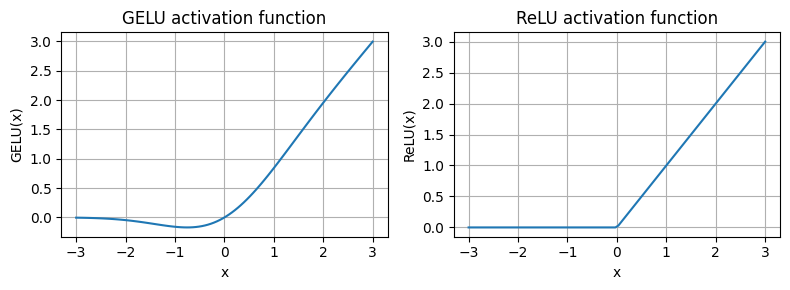

In [32]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()#先把函数给个小名

# Some sample data
x = torch.linspace(-3, 3, 100) #初定义一个张量
y_gelu, y_relu = gelu(x), relu(x) #两种激活函数

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()
#一个经典的作图

## PositionWiseFFN 基于位置的前馈神经网络
在原始 Transformer 论文、GPT-1、GPT-2 以及后续绝大多数基于 Transformer 的模型（包括 GPT-3, LLaMA 等）中，前馈网络（Feed-Forward Network, FFN）部分都采用了将输入维度扩大4倍，然后再还原回原始维度的结构。
> emb_dim -> 4 * emb_dim -> emb_dim

这已经成为了 Transformer 架构中的一个标准设计模式。

通过将输入 emb_dim 投影到一个更高维的空间（4 * emb_dim），模型在这个“更宽”的空间里有更多的能力去学习和拟合复杂的函数和模式。激活函数（如 GELU）在这个高维空间中进行操作，可以组合出比在原始低维空间中更丰富的特征。最后，第二个线性层再将这些丰富的信息“压缩”并投影回原始的 emb_dim，以便于后续的残差连接。

这个过程可以被直观地理解为一个**“记忆”或“特征提取器”**：

- 1.第一个线性层将注意力层的输出投影到一个巨大的“特征库”中。

- 2.GELU 激活函数根据输入，“点亮”或“激活”了库中相关的特征。

- 3.第二个线性层根据被激活的特征，重新组合成一个有意义的输出。

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(emb_dim, 4 * emb_dim),
            GELU(),
            nn.Linear(4 * emb_dim, emb_dim),
        )
    #运行一次就线性两次激活一次
    def forward(self, x):
        return self.layers(x)